In [15]:
import numpy as np
import scipy as sp
import pandas as pd
import datetime
from matplotlib import pyplot
pyplot.style.use("ggplot")
from sklearn.model_selection import train_test_split

In [111]:
events=pd.read_csv('/Users/yybai/Desktop/recommodation system/dataset/events.csv', nrows=100000)
category=pd.read_csv('/Users/yybai/Desktop/recommodation system/dataset/category_tree.csv')
item_properties=pd.read_csv('/Users/yybai/Desktop/recommodation system/dataset/item_properties_part1.csv', nrows=100000)

In [315]:
## turn time readable
for i in events.index:
    t=events.loc[i,'timestamp']
    time=datetime.datetime.fromtimestamp(int(str(t)[:10]))
    time=time.strftime('%Y-%m-%d %H:%M:%S')
    events.loc[i,'timestamp']=time

In [320]:
print(events.head(5))
print(category.head(5))
print(item_properties.head(5))

             timestamp  visitorid event  itemid  transactionid
0  2015-06-02 01:02:12     257597  view  355908            NaN
1  2015-06-02 01:50:14     992329  view  248676            NaN
2  2015-06-02 01:13:19     111016  view  318965            NaN
3  2015-06-02 01:12:35     483717  view  253185            NaN
4  2015-06-02 01:02:17     951259  view  367447            NaN
   categoryid  parentid
0        1016     213.0
1         809     169.0
2         570       9.0
3        1691     885.0
4         536    1691.0
       timestamp  itemid    property                            value
0  1435460400000  460429  categoryid                             1338
1  1441508400000  206783         888          1116713 960601 n277.200
2  1439089200000  395014         400  n552.000 639502 n720.000 424566
3  1431226800000   59481         790                       n15360.000
4  1431831600000  156781         917                           828513


In [78]:
## integrate parent id into item properties if necessary
item=item_properties
item['parent id']=None
dic={}
for row in category.iterrows():
    if pd.notna(row[1][0]):
            dic[row[1][0]]=row[1][1]

for i in item.index:
    if item.loc[i,'property']=='categoryid':
        if int(item.loc[i,'value']) in dic.keys():
            v=int(item.loc[i,'value'])
            item.loc[i,'parent id']=v

In [227]:
print(item_properties.value.dtype, item_properties.property.dtype)

object object


                **SELF DEFINED RATING SYSTEM**
Generating rating matrix, assuming that wiehgts for view, add to cart and buy = 1, 2, 4

resulting matrix row repre users, col repre item, val is rate

**note that it is based on events, so items not in events will be excluded from rating matrix**

In [ ]:
users=events.visitorid.unique()
items=events.itemid.unique()
matrix=pd.DataFrame(np.zeros((len(users), len(items))), index=users, columns=items)
for i in events.index:
    user, action, item=events.loc[i, ['visitorid','event','itemid']]
    if action=='view':
        matrix.loc[user,item]+=1
    elif action=='addtocart':
        matrix.loc[user,item]+=2
    elif action=='transaction':
        matrix.loc[user,item]+=4
print(matrix.head(30)) 

**For a new user, recommend the most popular products**

In [65]:
rating_of_allitems=matrix.sum(axis=0)
popular=rating_of_allitems.sort_values(ascending=False)

In [75]:
result=popular.head(5).index.tolist()
print(result)

[309778, 370653, 29196, 298009, 80858]


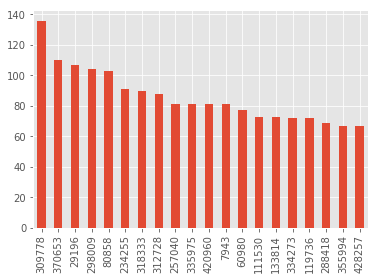

In [70]:
popular.head(20).plot(kind='bar')

                      **RECOMMEND BY COMMON SENSE, WITHOUT PREDICTING UNSEEN RATINGS**
- recommend 2 most popular (or all if # < 2) other items under same category id


- if items do not have category id, consider: buyers who bought the same product, recommend
    - if the user bought sth., recommend products bought by others who bought the sane product as the user
    - if the user has not bought but just has some viewed ones, recommend itmes viewed/added to cart/bought within certain time range by others who haved viewed the same product. This is a manual way for the first method, since items viewed together are most likely to be the substitutes or complements. 


- Make the above together to enhace. General idea is to find similar items then recommend by popularity.

**recommend 2 most popular (or all if # < 2) other items under same category id**

In [225]:

def rec_by_cate(user_choose):
    i=item_properties[item_properties.itemid==user_choose]
    ## check if the product has categoyid
    if i.head(1).property.values=='categoryid':
        ## get categoryid
        catid=i.head(1).value.values[0]
        ## get all items with same categoryid, if we want to eliminate the bias that many items have
        ## no iteraction with users, just stop here and randomly recommend
        all_items=item_properties[item_properties['value']==catid].itemid.tolist()
        ## get all of the above items that have an event (thus have rating)
        in_matrix=[i for i in all_items if i in matrix.columns]
        ## get their ratings, exclude rating for user_choose
        ratings=matrix[[i for i in in_matrix]].sum(axis=0).drop(labels=user_choose)
        ## if the number of remaining ratings >=2, get the highest 2. Otherwise get the full list
        try:
            most_populars=ratings.sort_values(ascending=False).head(2).index.tolist()
        except:
            most_populars=ratings.index.tolist()
        return most_populars    

In [226]:
rec_by_cate(194282)

[342833, 32368]

**recommend items bought by others who bought the same items**

In [276]:
## first generate a dict whose keys are buyers and values are items they buy
buyers=events[events.transactionid.notnull()].visitorid.unique().tolist()
buyer_item={}
for b in buyers:
    buyer_item[b]=events.loc[(events.visitorid==b) & (events.transactionid.notnull())].itemid.values.tolist()

In [277]:
buyer_item

{599528: [356475],
 121688: [15335,
  380775,
  237753,
  317178,
  12836,
  400969,
  105792,
  25353,
  200793,
  80582,
  302422],
 552148: [81345],
 102019: [150318, 49521],
 189384: [310791, 299044],
 350566: [54058,
  284871,
  251130,
  268335,
  183049,
  261940,
  369093,
  370745,
  192990,
  277119,
  241716],
 404403: [150100,
  50934,
  36013,
  26210,
  118199,
  234199,
  416187,
  167985,
  146735,
  4887],
 505565: [243566],
 945184: [245400],
 1406787: [336832],
 820159: [202052, 336832, 259078, 111306, 44882],
 319880: [7943],
 608628: [185598, 57245],
 956011: [338308],
 1318394: [318333, 318333],
 61806: [68242],
 1331125: [185896],
 911093: [277119, 251130, 261940],
 157419: [63769, 135703, 150185, 100367],
 1166562: [103311],
 464138: [428257],
 273406: [256146, 410587, 140527, 124065, 120098, 246997],
 1233140: [167827, 387504, 390167],
 813069: [201598],
 504901: [367664],
 1041255: [10034],
 328126: [159822],
 497826: [380493],
 666960: [89977],
 1161163: [383

In [307]:
## if we only want a list of all items bought by people who bogutht the item, we do not have to consider user.
## But for recommending, we don't want to include items bought by the user himself.
def rec1(user,bought_item):
    lst=buyer_item.values()
    recomm_list=[]
    for i in lst:
        if bought_item in i and buyer_item[user] != i:
            print(bought_item)
            recomm_list+=i
    recomm_list.remove(bought_item)
    return recomm_list

**recommend based on a viwed item: find others who also viewed/bought/added to cart that item, then find what else they viewed together with that one in a limited time range, say one day.**

**that will be a huge list, from the returned list we can then select by rating, or just randomly recommend**

In [348]:
def rec2(user,viewed):
    all_records=events[events.visitorid!=user].groupby(events.visitorid)
    recom_list=[]
    for name, group in all_records:
        date=group.loc[group['itemid']==viewed].timestamp.tolist()
        date=list(map(lambda x: x[:x.find(' ')],date))
        for i in group.itertuples():
            t=i.timestamp
            if t[:t.find(' ')] in date and i.itemid != viewed:
                recom_list.append(i.itemid)
    recom_list=list(set(recom_list))
    return recom_list
rec2(664876, 309778)

[76290,
 248327,
 336393,
 256521,
 279052,
 324109,
 346126,
 257040,
 388624,
 432152,
 88606,
 272926,
 381982,
 360487,
 393768,
 86057,
 257575,
 200231,
 313391,
 367664,
 258608,
 200242,
 444979,
 260148,
 71733,
 359990,
 294965,
 331311,
 265273,
 231482,
 140861,
 329279,
 334401,
 410697,
 447564,
 196177,
 182865,
 7765,
 292444,
 37471,
 147555,
 48743,
 403564,
 236141,
 102000,
 297593,
 6266,
 144507,
 287356,
 379520,
 131201,
 194179,
 248973,
 270478,
 235156,
 281749,
 301721,
 199838,
 260256,
 282789,
 76971,
 89262,
 293038,
 223203,
 115889,
 445105,
 152249,
 456889,
 276155,
 178362,
 152250,
 350399,
 69312,
 348352,
 75458,
 414410,
 174284,
 121553,
 357585,
 303828,
 135900,
 342749,
 2270,
 120541,
 24291,
 147684,
 425700,
 91875,
 239333,
 140527,
 188148,
 452852,
 387318,
 212216,
 354555,
 175356,
 200445,
 208637,
 270081,
 98051,
 127969,
 402696,
 397068,
 288525,
 3854,
 304400,
 320786,
 197394,
 2836,
 448274,
 347414,
 295191,
 382751,
 33308

**Recommend based on user item interaction matrix where the entries are ratings. Use ALS for matrix factorization**

**Here we use implicit library to build the model**

**The model uses item-user matrix to train, and recommend based on user-item matrix**

In [414]:
m=matrix
m.to_sparse()
user_item=m
item_user=user_item.T

In [419]:
X=sp.sparse.csr_matrix(item_user.values)
X_ui=sp.sparse.csr_matrix(user_item.values)

In [420]:
import implicit
model = implicit.als.AlternatingLeastSquares(factors=20, regularization=0.1, iterations=20)
alpha_val = 15
data_conf = (X*alpha_val).astype('double')

In [421]:
model.fit(data_conf)

100%|██████████| 20.0/20 [00:02<00:00,  9.18it/s]


In [444]:
## for the first user (257597), the following is the recommended items' index slong with scores
recommended = model.recommend(0, X_ui)
print(recommended)

[(49, 0.00820731), (72, 0.007910712), (3196, 0.0071776365), (7569, 0.0068724873), (45, 0.0065238094), (5051, 0.0059903357), (9161, 0.0049486104), (2110, 0.004424409), (5143, 0.0043273577), (2353, 0.003987248)]


In [450]:
result_items = []
result_scores = []

for i in recommended:
    idx, score = i
    result_items.append(matrix.iloc[:,idx].name)
    result_scores.append(score)

result_recommendations = pd.DataFrame({'product':result_items,'score': result_scores})
result_recommendations

,product,score
0,16813,0.008207
1,391289,0.007911
2,175356,0.007178
3,152433,0.006872
4,280375,0.006524
5,267347,0.005990
6,235771,0.004949
7,142466,0.004424
8,167543,0.004327
9,215904,0.003987


**The resulting scores are mostly very low. At first the weights are assigned to 1,2,4, but recommendation scores are smaller than 1. To some extent, this difference may indicate that recommendation system by predicting ratings is not the best method or should be used together with other techniques. The method for assigning weights affects the result as well.**

                                **FURTHER IMPROVING IDEAS**

- how to improve the weighting method of view, add to cart and buy (1, 2, 4 is too bias)


- since item properties and events are seperated, the rating matrix is only based on items that have been viewed or added or bought. Items with no iteraction with users are totally ignored. But generating a whole rating matrix, including all items is not feasible since that will be extremely huge. Should develop a way to reduce the range


- data is too messy and unorganized. Should build non sql database to store and organize